# Ultimate Data Challenge

## Summary

The number of users retained is lower than the number of users not retained resulting in a unbalanced data set.  I utilized three different techniques to compensate for the unbalanced data as follows: 


- Method 1 - Optimize ROC AUC and tune parameters
- Method 2 - Optimize cutoff value
- Method 3 - SMOTE oversampling


Methods 1 and 3 were very good at estimating users who were not active (retained) but did poorly predicting retained users.  While retaining the same accuracy in the other two models, Method 2 was significantly more effective at predicting retained users.  The confusion matrix for each method is provided below.





Method 1 - Optimize ROC AUC and tune paramaters
![title](images/Optimize_roc_auc.png)

Method 2 - Optimize cutoff value
![title](images/Optimize_cutoff_value.png)

Method 3 - SMOTE oversampling
![title](images/SMOTE_oversampling_confusion_matrix.png)

## Part 3 code

## Housekeeping

In [1]:
import calendar
from datetime import datetime, timedelta
import json
import lightgbm  as  lgb
from lightgbm import LGBMClassifier
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, PercentFormatter, StrMethodFormatter
import numpy as np
import pandas as pd
from pathlib import Path
import random
import seaborn as sns
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    SCORERS,  # # sorted(SCORERS.keys())
    confusion_matrix,
    classification_report,
    plot_confusion_matrix,
    roc_curve
)
from sklearn.discriminant_analysis import (
    QuadraticDiscriminantAnalysis,
    LinearDiscriminantAnalysis,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, binarize
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
import time
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
%matplotlib inline

C:\Users\ThomasWiddows\Anaconda3\envs\sb_ultimate_take_home\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
DATA_DIR = Path.cwd()
MAX_EVALS =  5
N_FOLDS = 5

### Utility functions

In [3]:
# save pickle
def save_obj(obj, name):
    import pickle
    with open(DATA_DIR / str(name + '.pkl'), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# load pickle
def load_obj(name ):
    import pickle
    with open(DATA_DIR / str(name + '.pkl'), 'rb') as f:
        return pickle.load(f)

# print blank lines
def bl(qty=1):
    for l in range(qty):
        print()

### Helper functions

In [4]:
# return best thresholds
def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]
    
# plot histogram of predicted probability
def pred_prob_hist(X_valid, bins=8, xlabel='positive', cutoff=0.5):
    plt.hist(y_pred_prob, bins=bins)
    plt.xlim(0,1)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.axvline(x=cutoff, ymin=0, ymax=1, color='r', linewidth=3,  linestyle='--')
    plt.title("Histogram of predicted probabilities")
    plt.xlabel("Predicted probability of "+xlabel)
    plt.ylabel('Frequency');
    colors = ['darkred']
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
    labels = ['Cutoff']
    plt.legend(lines, labels)
    plt.show();
    bl()

    
# plot feature importances
def feat_imp_plot(df, model, n_features):
    d = dict(zip(df.columns, model.feature_importances_))
    ss = sorted(d, key=d.get, reverse=True)
    top_names = ss[0:n_features]
    plt.figure(figsize=(15, 5))
    plt.title("Feature importances")
    plt.bar(range(n_features), [d[i] for i in top_names], color="r", align="center")
    plt.xlim(-1, n_features)
    plt.xticks(range(n_features), top_names, rotation="vertical")

    
# draw diag line
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')


# plot roc curve
def plot_roc_curve(y_valid, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob.ravel())
    optimal_cutoff = cutoff_youdens_j(fpr,tpr,thresholds)
    y_pred_class = binarize(y_pred_prob.reshape(1,-1), optimal_cutoff) 
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class.ravel()).ravel()
    false_positive_rate = fp / (fp + tn)
    true_positive_rate = tp / (tp + fn)

    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect('equal', adjustable='box')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)
    plt.title('ROC curve for retained customers\n', fontsize=16)
    plt.xlabel('False Positive Rate\nFP / (FP + TN)', fontsize=14)  # : (1 - Specificity)
    plt.ylabel('True Positive Rate (Recall)\nTP / (TP + FN)', fontsize=14)  # : (Recall)
    plt.grid(True)
    abline(slope=1,intercept=0)
    ax.axvline(x=false_positive_rate, ymin=0, ymax=true_positive_rate, color='r', linestyle='--')
    ax.axhline(y=true_positive_rate, xmin=0, xmax=false_positive_rate, color='r', linestyle='--')
    return optimal_cutoff


# plot confusion matrix plus
def plot_cm_plus(tn, fp, fn, tp):
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as path_effects
    from matplotlib import transforms
    import numpy as np

    def range_brace(x_min, x_max, mid=0.75, 
                    beta1=50.0, beta2=100.0, height=1, 
                    initial_divisions=11, resolution_factor=1.5):
        # determine x0 adaptively values using second derivitive
        # could be replaced with less snazzy:
        #   x0 = NP.arange(0, 0.5, .001)
        x0 = np.array(())
        tmpx = np.linspace(0, 0.5, initial_divisions)
        tmp = beta1**2 * (np.exp(beta1*tmpx)) * (1-np.exp(beta1*tmpx)) / np.power((1+np.exp(beta1*tmpx)),3)
        tmp += beta2**2 * (np.exp(beta2*(tmpx-0.5))) * (1-np.exp(beta2*(tmpx-0.5))) / np.power((1+np.exp(beta2*(tmpx-0.5))),3)
        for i in range(0, len(tmpx)-1):
            t = int(np.ceil(resolution_factor*max(np.abs(tmp[i:i+2]))/float(initial_divisions)))
            x0 = np.append(x0, np.linspace(tmpx[i],tmpx[i+1],t))
        x0 = np.sort(np.unique(x0)) # sort and remove dups
        # half brace using sum of two logistic functions
        y0 = mid*2*((1/(1.+np.exp(-1*beta1*x0)))-0.5)
        y0 += (1-mid)*2*(1/(1.+np.exp(-1*beta2*(x0-0.5))))
        # concat and scale x
        x = np.concatenate((x0, 1-x0[::-1])) * float((x_max-x_min)) + x_min
        y = np.concatenate((y0, y0[::-1])) * float(height)
        return (x,y)

    fig  = plt.figure(figsize=(18, 9))
    grid_shape = (39,37)

    axes_list = ['ax_n1', 'ax_n2', 'ax_predicted_negative', 'ax_predicted_positive', 'ax_actual_negative', 'ax_actual_positive', 
    'ax_true_negative', 'ax_false_positive',  'ax_false_negative', 'ax_true_positive', 'ax_total_predicted_negative', 'ax_total_predicted_positive',  'ax_total_actual_negative', 'ax_total_actual_positive', 'ax_precision', 'ax_negative_predictive_value',  'ax_accuracy', 'ax_f1', 'ax_specificity', 'ax_sensitivity',  'ax_predicted_class', 'ax_actual_class', 'ax_top_brace', 'ax_left_brace']
    typex = ['coordinates', 'spans', 'facecolor', 'spines']
    coordinates = [[(6,3),(2,4), 'w', False], [(24,23),(4,5), 'lavender', True], [(6,7),(2,8), 'pink', True], [(6,15),(2,8), 'pink', True], [(8,3),(8,4), 'pink', True], [(16,3),(8,4), 'pink', True], [(8,7),(8,8), 'w', True], [(8,15),(8,8), 'w', True], [(16,7),(8,8), 'w', True], [(16,15),(8,8), 'w', True], [(24,7),(4,8), 'lavender', True], [(24,15),(4,8), 'lavender', True], [(8,23),(8,5), 'lavender', True], [(16,23),(8,5), 'lavender', True], [(30,15),(9,8), 'antiquewhite', True], [(30,7),(9,8), 'antiquewhite', True], [(30,25),(9,6), 'antiquewhite', True], [(30,31),(9,6), 'antiquewhite', True], [(8,29),(8,8), 'antiquewhite', True], [(16,29),(8,8), 'antiquewhite', True], [(0,7),(2,16), 'w', False], [(8,0),(16,1), 'w', False], [(2,7),(3,16), 'w', False], [(8,1),(16,1), 'w', False]   ]
    d = {}
    for ax, coordinates in zip(axes_list, coordinates):
        d[ax] = dict(zip(typex, coordinates))
    axes={}    
    for ax, v in d.items():
        loc = d[ax]['coordinates']
        rowspan, colspan = d[ax]['spans']
        facecolor = d[ax]['facecolor']
        spines = d[ax]['spines']
        axes[ax] = plt.subplot2grid(shape=grid_shape, loc=loc, rowspan=rowspan, colspan=colspan, facecolor=facecolor, xticks=[], yticks=[])
        for sp in axes[ax].spines.values():
            sp.set_visible(spines)

    # draw the top brace
    x,y = range_brace(0, 1)
    axes['ax_top_brace'].set_xlim(0,1)
    axes['ax_top_brace'].set_ylim(0,1)
    axes['ax_top_brace'].plot(x, y,'-', clip_on=False)

    # draw the left brace
    x,y = range_brace(0, 1)
    axes['ax_left_brace'].set_xlim(0,1)
    axes['ax_left_brace'].set_ylim(0,1)    
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg_around(.5, .5, 90)
    axes['ax_left_brace'].plot(x, y,'-', clip_on=False, transform=rot+base)

    typexx = ['ax', 'coord', 'text', 'align', 'fontsize', 'weight', 'color', 'path_effectsx', 'rotationx']
    text_list = [
        ['ax_n2',(.5, .7), 'Total', ('center', 'center'), 20, 'normal', 'black', False, 0], 
        ['ax_n2',(.5, .3), f'{(tn+tp+fn+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_predicted_negative',(.5, .5), 'Negative', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_predicted_positive',(.5, .5), 'Positive', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_negative',(.5, .5), 'Negative', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_positive',(.5, .5), 'Positive', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_true_negative',(.5, .7), 'True Negative (TN)', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_true_negative',(.5, .3), f'{tn:,.0f}', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_false_positive',(.5, .8), 'False Positive (FP))', ('center', 'center'), 18, 'normal', 'red', True, 0],
        ['ax_false_positive',(.5, .55), '(Type I Error)', ('center', 'center'), 16, 'normal', 'darkred', False, 0],
        ['ax_false_positive',(.5, .3), f'{fp:,.0f}', ('center', 'center'), 20, 'normal', 'red', False, 0],
        ['ax_false_negative',(.5, .8), 'False Negative (FN)', ('center', 'center'), 18, 'normal', 'red', True, 0],
        ['ax_false_negative',(.5, .55), '(Type II Error)', ('center', 'center'), 16, 'normal', 'darkred', False, 0],
        ['ax_false_negative',(.5, .3), f'{fn:,.0f}', ('center', 'center'), 20, 'normal', 'red', False, 0],
        ['ax_true_positive',(.5, .7), 'True Positive (TP)', ('center', 'center'), 18, 'normal', 'green', True, 0],
        ['ax_true_positive',(.5, .3), f'{tp:,.0f}', ('center', 'center'), 20, 'normal', 'green', False, 0],
        ['ax_total_predicted_negative',(.5, .7), 'Total Predicted Negative', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_predicted_negative',(.5, .3), f'{(tn+fn):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_predicted_positive',(.5, .7), 'Total Predicted Positive', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_predicted_positive',(.5, .3), f'{(tp+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_actual_negative',(.5, .7), 'Total\nActual Negative', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_actual_negative',(.5, .3), f'{(tn+fp):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_total_actual_positive',(.5, .7), 'Total\nActual Positive', ('center', 'center'), 14, 'normal', 'black', False, 0],
        ['ax_total_actual_positive',(.5, .3), f'{(tp+fn):,.0f}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .8), 'Precision\nPositive Predictive Value', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .45), r'$\frac{TP}{TP+FP}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_precision',(.5, .1), f'{tp / (tp+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .8), 'Negative Predictive Value', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .45), r'$\frac{TN}{TN+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_negative_predictive_value',(.5, .1), f'{tn / (tn+fn):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .8), 'Accuracy', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .45), r'$\frac{TP+TN}{TP+TN+FP+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_accuracy',(.5, .1), f'{(tn+tp) / (tn+tp+fn+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .8), 'F1 Score', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .45), r'$2\left(\frac{(Precision)(Recall)}{Precision + Recall}\right)$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_f1',(.5, .1), f'{2*(((tp/(tp+fp)) * (tp/(tp+fn))) / ((tp/(tp+fp)) + (tp/(tp+fn)))):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .8), 'True Negative Rate (TNR)\nSpecificity', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .425), r'$\frac{TN}{TN+FP}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_specificity',(.5, .1), f'{(tn) / (tn+fp):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .8), 'True Positive Rate (TPR)\nSensitivity or Recall', ('center', 'center'), 15, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .425), r'$\frac{TP}{TP+FN}$', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_sensitivity',(.5, .1), f'{(tp) / (tp+fn):.2%}', ('center', 'center'), 20, 'normal', 'black', False, 0],
        ['ax_predicted_class',(.5, .5), 'Predicted Class', ('center', 'center'), 15, 'bold', 'black', False, 0],
        ['ax_actual_class',(.5, .5), 'Actual Class', ('center', 'center'), 15, 'bold', 'black', False, 90]]

    d2 = {}
    for ax, text_list in zip(range(len(text_list)), text_list):
        d2[ax] = dict(zip(typexx, text_list))

    for key, value in d2.items():
        x, y = value['coord']
        txt = value['text']
        va, ha = value['align']
        fontsize = value['fontsize']
        weight = value['weight']
        color = value['color']
        path_effectsx = value['path_effectsx']
        if path_effectsx == True:
            path_effects_var = [path_effects.withSimplePatchShadow()]
        else:
            path_effects_var = False
        rotationx = value['rotationx']

        axes[d2[key]['ax']].text(x=x, y=y, s=txt, va=va, ha=ha, fontsize=fontsize, weight=weight, color=color, path_effects=path_effects_var, rotation=rotationx)

    plt.suptitle('Confusion Matrix Plus', fontsize=30)
    plt.subplots_adjust(wspace=0, hspace=0)
    print('')
    plt.show()
    return fig
    

In [5]:
# Algorithms to try
classification_algos_name = [
    "KNeighborsClassifier",
    "GaussianNB",
    "MultinomialNB",
    "DecisionTreeClassifier",
    "ExtraTreeClassifier",
    "LinearDiscriminantAnalysis",
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier",
    "XGBClassifier",
    "LGBMClassifier",
]

classification_algos = [
    KNeighborsClassifier(),
    GaussianNB(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    LinearDiscriminantAnalysis(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
]

# Read, clean and wrangle data

In [6]:
df_ultimate = pd.read_json('ultimate_data_challenge.json')
df_ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [7]:
df_ultimate['last_trip_date'].max()

'2014-07-01'

In [8]:
df_ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [9]:
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [10]:
df_ultimate.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

### Clean data

In [11]:
# convert signup date to ordinal
df_ultimate['signup_date'] = pd.to_datetime(df_ultimate['signup_date'].astype('datetime64[ns]'))
df_ultimate['signup_date'] = df_ultimate['signup_date'].map(datetime.toordinal)


# calculate retained field based on last_trip_date and convert last_trip_date to ordinal
df_ultimate['last_trip_date'] = pd.to_datetime(df_ultimate['last_trip_date'].astype('datetime64[ns]'))
retained_window = df_ultimate['last_trip_date'].max() - pd.Timedelta(days=30)
df_ultimate['retained'] = df_ultimate['last_trip_date'] >= retained_window
df_ultimate.drop(['last_trip_date'], axis=1, inplace=True)

# fill na data with averages
df_ultimate['avg_rating_of_driver'].fillna(df_ultimate['avg_rating_of_driver'].mean(), inplace=True)
df_ultimate['avg_rating_by_driver'].fillna(df_ultimate['avg_rating_by_driver'].mean(), inplace=True)

# populate blank phone type data
df_ultimate['phone'].fillna('Generic', inplace=True)

print(f'To be active, user must have taken a trip on or after {retained_window.strftime("%m/%d/%Y")}.')
bl()
print(f'{"Retained customers:":<33} {df_ultimate["retained"].sum():,.0f}')
print(f'{"Total customers:":<33} {df_ultimate["retained"].count():,.0f}')
print(f'{"Percent of Retained customers:":<34} {((df_ultimate["retained"].sum()) / (df_ultimate.shape[0])):.2%}')
# hyperopt paramater
scale_pos_weight_param = (df_ultimate["retained"].sum()) / (df_ultimate.shape[0]) # positive samples / negative samples
df_ultimate = df_ultimate.reindex(sorted(df_ultimate.columns), axis=1)
df_ultimate.head()

To be active, user must have taken a trip on or after 06/01/2014.

Retained customers:               18,804
Total customers:                  50,000
Percent of Retained customers:     37.61%


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,retained,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,True,735258,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,Android,False,735262,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,False,735239,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,True,735243,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,False,735260,11.8,14,False,82.4


In [12]:
# code catagorical columns
cat_cols = df_ultimate.select_dtypes(include=['object']).columns
print(f'Catagorical columns: {cat_cols}')
for col in cat_cols:
    dummies = pd.get_dummies(df_ultimate[col]).rename(columns=lambda x:  col + '_' + str(x))
    df_ultimate = pd.concat([df_ultimate, dummies], axis=1)
    df_ultimate.drop([col], inplace=True, axis=1)
df_ultimate.head()

Catagorical columns: Index(['city', 'phone'], dtype='object')


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,retained,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Generic,phone_iPhone
0,3.67,5.0,4.7,1.10,True,735258,15.4,4,True,46.2,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,False,735262,0.0,0,False,50.0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,False,735239,0.0,3,False,100.0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,True,735243,20.0,9,True,80.0,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,False,735260,11.8,14,False,82.4,0,0,1,1,0,0


### Check distribution

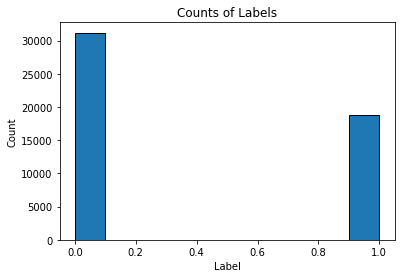

In [13]:
plt.hist(df_ultimate['retained'].astype('int'), edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

The data is unbalanced

In [14]:
print(f'Correlation with retained')
df_ultimate.corr(method ='pearson') ['retained'].sort_values(ascending=False)[1:]

Correlation with retained


city_King's Landing       0.262284
phone_iPhone              0.225244
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
phone_Generic            -0.007419
avg_rating_of_driver     -0.010829
signup_date              -0.020211
avg_rating_by_driver     -0.026748
city_Winterfell          -0.046611
avg_dist                 -0.092780
city_Astapor             -0.174655
phone_Android            -0.225464
Name: retained, dtype: float64

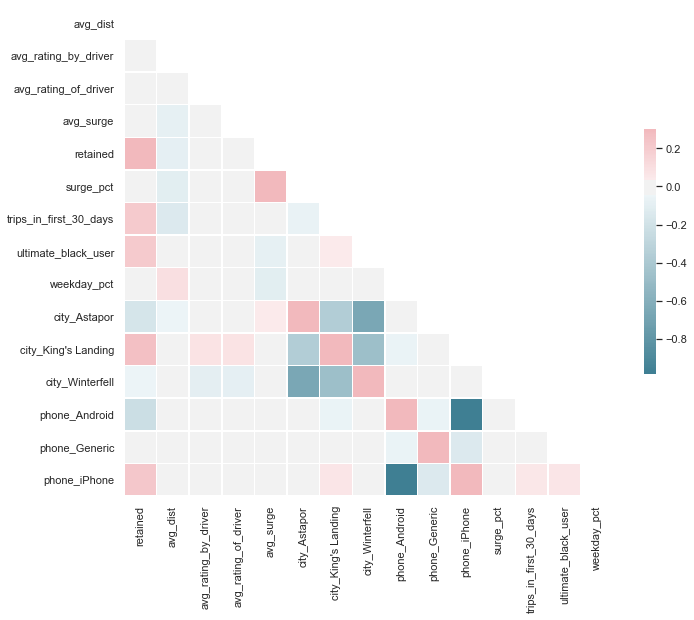

In [15]:
sns.set(style="white")

# Compute the correlation matrix
df_corr = df_ultimate.corr()
first_col = 'retained'
df_corr = df_corr.reindex(columns=sorted(df_corr.columns))
df_corr = df_corr.reindex(columns=([first_col] + list([a for a in df_corr.columns if a != first_col]) ))
df_corr.drop('signup_date', inplace=True, axis=0)
df_corr.drop('signup_date', inplace=True, axis=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Split data in train, validate and test (holdout)

In [16]:
# split the data
X = df_ultimate.drop("retained", axis=1)
y = df_ultimate["retained"]

X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(
    X, y, test_size=0.1, random_state=50, stratify=y
)
# Separate remainder into training and validation data for optimization
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_and_valid,
    y_train_and_valid,
    test_size=0.2,
    random_state=50,
    stratify=y_train_and_valid,
)

print(f'{"Total Data:":<28}{X.shape[0]:7,.0f}{1:6.0%}  {"X"}')
bl()
print(f'{"Test (holdout) data:":<28}{X_test.shape[0]:7,.0f}{.1:6.0%}  {"X_test"}')
print(
    f'{"Train and Validation data:":<28}{X_train_and_valid.shape[0]:7,.0f}{.9:6.0%}  {"X_train_and_valid"}'
)
bl()
print(f'{"Train data:":<28}{X_train.shape[0]:7,.0f}{.72:6.0%}  {"X_train"}')
print(f'{"Validation data:":<28}{X_valid.shape[0]:7,.0f}{.18:6.0%}  {"X_valid"}')

Total Data:                  50,000  100%  X

Test (holdout) data:          5,000   10%  X_test
Train and Validation data:   45,000   90%  X_train_and_valid

Train data:                  36,000   72%  X_train
Validation data:              9,000   18%  X_valid


## Classifier selection

In [17]:
accuracy_score_list = []
f1_score_list = []
precision_score_list = []
recall_score_list = []
roc_auc_score_list = []

print(
    f'{"classsifier":<30} {"accuracy":<6}  {"f1_score":<6}  {"precision":<7}    {"recall":<6}   {"roc_auc":<6}  {"time":<15}'
)


for idx, mod in enumerate(classification_algos):
    start = time.time()
    model = mod
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    end = time.time()
    recall_score_list.append(recall_score(y_valid, y_valid_pred))
    precision_score_list.append(precision_score(y_valid, y_valid_pred))
    f1_score_list.append(f1_score(y_valid, y_valid_pred))
    accuracy_score_list.append(accuracy_score(y_valid, y_valid_pred))
    roc_auc_score_list.append(roc_auc_score(y_valid, y_valid_pred))

    print(
        f"{classification_algos_name[idx]:<30} {accuracy_score_list[idx]:>8.2%}  {f1_score_list[idx]:>8.2%}  {precision_score_list[idx]:>9.2%}  {recall_score_list[idx]:>8.2%}  {roc_auc_score_list[idx]:>8.2%}  {end-start:.2f} sec"
    )

classsifier                    accuracy  f1_score  precision    recall   roc_auc  time           
KNeighborsClassifier             72.56%    61.95%     64.72%    59.41%    69.95%  1.08 sec
GaussianNB                       69.93%    64.05%     58.19%    71.23%    70.19%  0.05 sec
MultinomialNB                    65.89%    50.18%     55.67%    45.67%    61.87%  0.04 sec
DecisionTreeClassifier           70.09%    60.38%     60.16%    60.59%    68.20%  0.25 sec
ExtraTreeClassifier              70.19%    60.29%     60.41%    60.18%    68.20%  0.10 sec
LinearDiscriminantAnalysis       71.44%    55.21%     67.32%    46.79%    66.55%  0.13 sec
RandomForestClassifier           77.32%    68.38%     71.89%    65.20%    74.91%  3.57 sec
AdaBoostClassifier               77.22%    68.03%     72.05%    64.43%    74.68%  2.52 sec
GradientBoostingClassifier       78.02%    69.28%     73.04%    65.88%    75.61%  3.43 sec
XGBClassifier                    78.00%    69.29%     72.94%    66.00%    75.62%  1

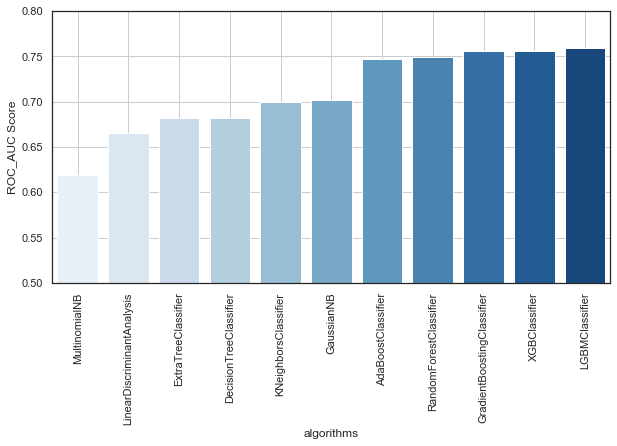

In [18]:
df_feature_importance = pd.DataFrame(
    {"algorithms": classification_algos_name, 
     "roc_auc": roc_auc_score_list,
      "recall": recall_score_list,
      "f1": f1_score_list,
      "precision": precision_score_list,
      "accuracy": accuracy_score_list}
)
df_feature_importance.set_index(keys='algorithms', drop=True, inplace=True)
df_feature_importance.sort_values(by='roc_auc', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(df_feature_importance.index, df_feature_importance['roc_auc'], palette='Blues')
plt.xticks(rotation=90)
plt.ylim([.5,.8])
plt.ylabel('ROC_AUC Score')
plt.grid(True)

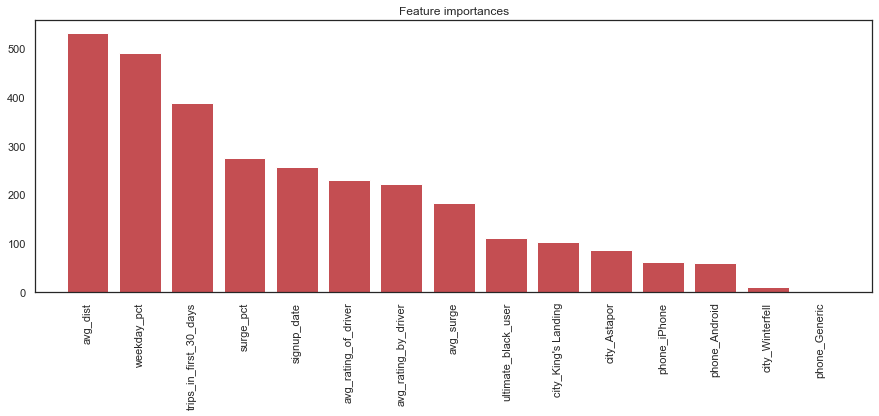

In [19]:
feat_imp_plot(X_train, model, X_train.shape[1])

## LightGBM

### Recursive feature elimination

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

Optimal number of features : 12


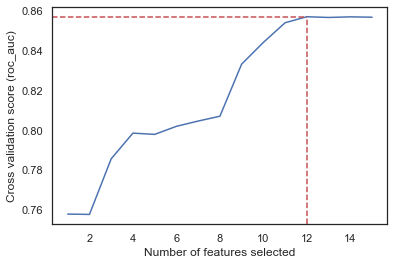

In [21]:
# create the RFE model and select best attributes
rfecv = RFECV(model, cv=StratifiedKFold(5), scoring='roc_auc')
rfecv = rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# summarize the ranking of the attributes
fea_rank_ = pd.DataFrame({'cols':X_train.columns, 'fea_rank':rfecv.ranking_})
fea_rank_.loc[fea_rank_.fea_rank > 0].sort_values(by=['fea_rank'], ascending = True)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (roc_auc)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
optimal_score = rfecv.grid_scores_[rfecv.n_features_+1]
ax = plt.gca()
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
y_max_pct = (optimal_score - y_min) / (y_max - y_min)
x_max_pct = (rfecv.n_features_ - x_min) / (x_max - x_min)
plt.axvline(x=rfecv.n_features_, ymin=0, ymax=y_max_pct, color='r', linestyle='--')
plt.axhline(y=optimal_score, xmin=0, xmax=x_max_pct, color='r', linestyle='--')
plt.show()

In [22]:
# drop features
cols = fea_rank_[fea_rank_['fea_rank']>1]['cols']
for col in cols:
    X_train.drop(col, axis=1, inplace=True)
    X_valid.drop(col, axis=1, inplace=True)
    X_test.drop(col, axis=1, inplace=True)
    X_train_and_valid.drop(col, axis=1, inplace=True)
    print(f'Dropping...{col}')

Dropping...city_Winterfell
Dropping...phone_Android
Dropping...phone_Generic


In [23]:
# Create a lgb dataset
train_set = lgb.Dataset(X_train, label = y_train) # used in lgb cross validation

## Method 1 - Optimize ROC AUC and tune parameters

In [24]:
# Model with default hyperparameters
model = lgb.LGBMClassifier(silent=False)  
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

The baseline score (roc_auc) on the validation set is 85.67%
The baseline training time is 0.46 seconds

               precision    recall  f1-score   support

       False     0.8079    0.8591    0.8327      5615
        True     0.7389    0.6612    0.6978      3385

    accuracy                         0.7847      9000
   macro avg     0.7734    0.7601    0.7653      9000
weighted avg     0.7819    0.7847    0.7820      9000
 




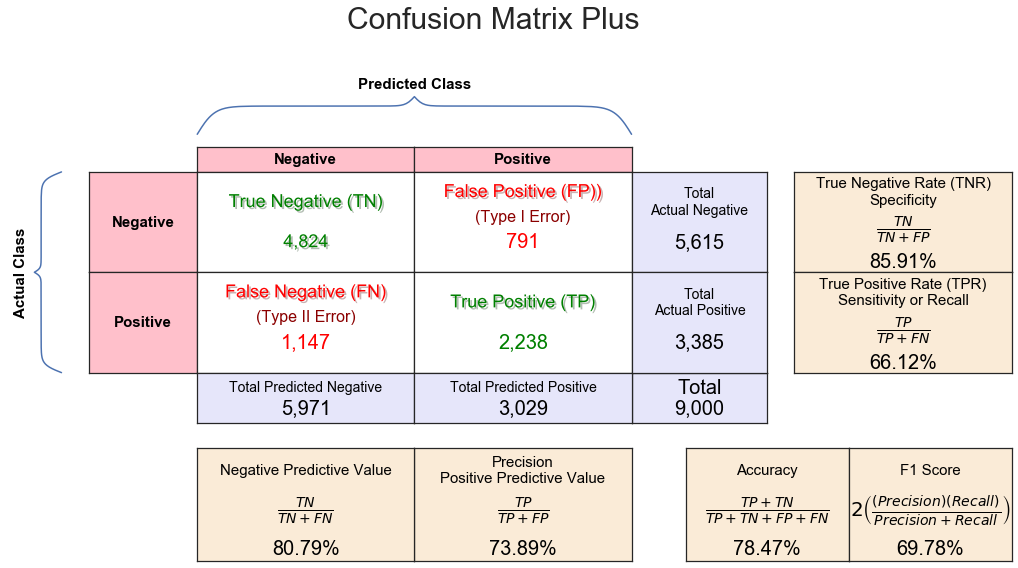

In [25]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(X_train, y_train)
train_time = timer() - start

preds = model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, preds)

print(f'The baseline score (roc_auc) on the validation set is {auc:.2%}')
print(f'The baseline training time is {train_time:.2f} seconds')

preds = preds.reshape(-1,1)
y_pred_class = binarize(preds, 0.5)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
print('\n', classification_report(y_valid, y_pred_class, digits=4), '\n');
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)

### Tune Model

In [26]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 500, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [27]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [28]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

In [29]:
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}

In [30]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'goss', 'subsample': 1.0}}

In [31]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'goss', 'subsample': 1.0}

In [32]:
# Define the search space
space = {
#     'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'scale_pos_weight': hp.choice('scale_pos_weight', [1, scale_pos_weight_param]),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', -6, -2.3),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [33]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'goss',
 'colsample_bytree': 0.9656264748145645,
 'learning_rate': 0.0036779406350876316,
 'min_child_samples': 325.0,
 'num_leaves': 91.0,
 'reg_alpha': 0.24718155974826939,
 'reg_lambda': 0.7635394062665951,
 'scale_pos_weight': 0.37608,
 'subsample_for_bin': 120000.0,
 'subsample': 1.0}

In [34]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

In [35]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [36]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [37]:
from hyperopt import fmin

In [38]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50),
           show_progressbar=True)

In [39]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:1] # show best trial

[{'loss': 0.14641283576732023,
  'params': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.6788868056725463,
   'learning_rate': 0.00461006275829445,
   'min_child_samples': 210,
   'num_leaves': 63,
   'reg_alpha': 0.16832420777297208,
   'reg_lambda': 0.10452971963792468,
   'scale_pos_weight': 1,
   'subsample_for_bin': 140000,
   'subsample': 0.6778711248241811},
  'iteration': 4,
  'estimators': 500,
  'train_time': 11.378428599999996,
  'status': 'ok'}]

In [40]:
results = pd.read_csv('gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.146413,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",4,500,11.378429
1,0.146790,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",2,500,8.676134
2,0.151665,"{'boosting_type': 'goss', 'colsample_bytree': ...",1,314,6.313932
3,0.152384,"{'boosting_type': 'goss', 'colsample_bytree': ...",5,12,1.582662
4,0.154294,"{'boosting_type': 'goss', 'colsample_bytree': ...",3,312,7.567309


In [41]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6788868056725463,
 'learning_rate': 0.00461006275829445,
 'min_child_samples': 210,
 'num_leaves': 63,
 'reg_alpha': 0.16832420777297208,
 'reg_lambda': 0.10452971963792468,
 'scale_pos_weight': 1,
 'subsample_for_bin': 140000,
 'subsample': 0.6778711248241811}

In [42]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train and validation data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6788868056725463, importance_type='split',
               learning_rate=0.00461006275829445, max_depth=-1,
               min_child_samples=210, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=63,
               objective='binary', random_state=50,
               reg_alpha=0.16832420777297208, reg_lambda=0.10452971963792468,
               scale_pos_weight=1, silent=True, subsample=0.6778711248241811,
               subsample_for_bin=140000, subsample_freq=0)

### Predict on validation data using Bayes optimized paramaters

The best model from Bayes optimization scores 85.13% AUC ROC on the validation set.
This was achieved after 4 search iterations

               precision    recall  f1-score   support

       False     0.7895    0.8712    0.8284      5615
        True     0.7422    0.6148    0.6725      3385

    accuracy                         0.7748      9000
   macro avg     0.7658    0.7430    0.7504      9000
weighted avg     0.7717    0.7748    0.7697      9000
 




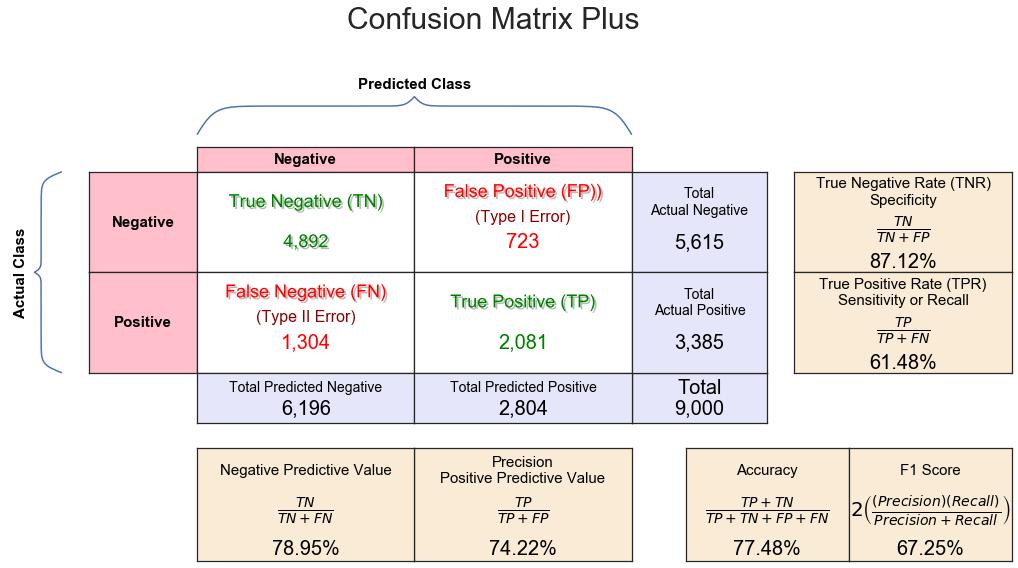

In [43]:
# Evaluate best model on the validation data 
preds = best_bayes_model.predict_proba(X_valid)[:, 1]
print('The best model from Bayes optimization scores {:.2%} AUC ROC on the validation set.'.format(roc_auc_score(y_valid, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))
preds = preds.reshape(-1,1)
y_pred_class = binarize(preds, 0.5)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
print('\n', classification_report(y_valid, y_pred_class, digits=4), '\n');
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)

### Predict on testing data using Bayes optimized paramaters

In [44]:
# retrain model with best paramaters using train and validation data
best_bayes_model.fit(X_train_and_valid, y_train_and_valid)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6788868056725463, importance_type='split',
               learning_rate=0.00461006275829445, max_depth=-1,
               min_child_samples=210, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=63,
               objective='binary', random_state=50,
               reg_alpha=0.16832420777297208, reg_lambda=0.10452971963792468,
               scale_pos_weight=1, silent=True, subsample=0.6778711248241811,
               subsample_for_bin=140000, subsample_freq=0)

The best model from Bayes optimization scores 85.94% AUC ROC on the test set.
This was achieved after 4 search iterations

               precision    recall  f1-score   support

       False     0.7917    0.8878    0.8370      3120
        True     0.7668    0.6122    0.6809      1880

    accuracy                         0.7842      5000
   macro avg     0.7792    0.7500    0.7589      5000
weighted avg     0.7823    0.7842    0.7783      5000
 




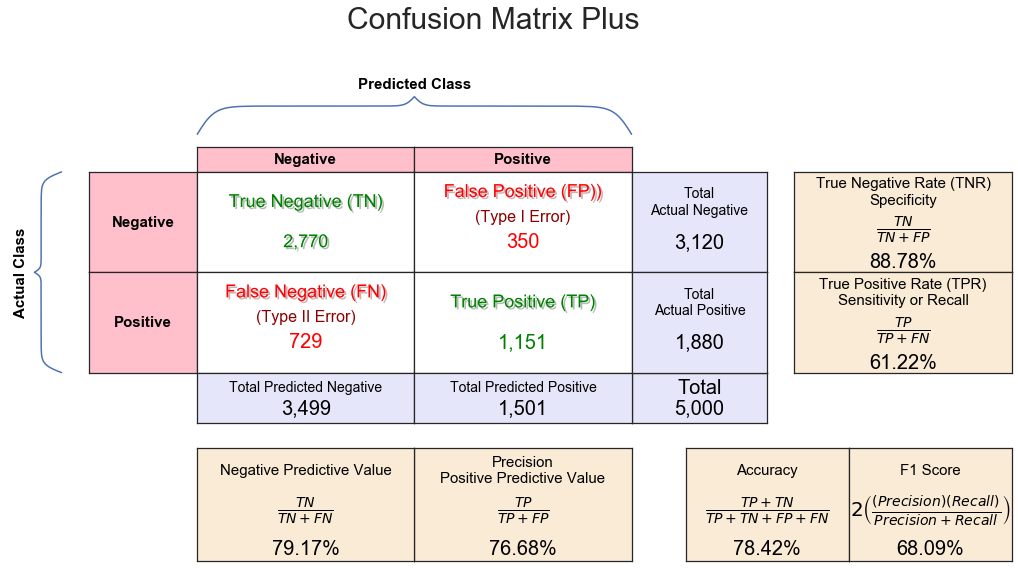

In [45]:
# predict on test data
preds = best_bayes_model.predict_proba(X_test)[:, 1]
print('The best model from Bayes optimization scores {:.2%} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))
preds = preds.reshape(-1,1)
y_pred_class = binarize(preds, 0.5)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
print('\n', classification_report(y_test, y_pred_class, digits=4), '\n');
fig = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
fig.savefig('images/Optimize_roc_auc')

## Method 2 - Optimize cutoff value

In [46]:
# Model with default hyperparameters
model = lgb.LGBMClassifier()
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [47]:
from timeit import default_timer as timer

start = timer()
model.fit(X_train, y_train)
train_time = timer() - start

y_pred_prob = model.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred_prob)

print('The baseline score (roc_auc) on the validation set is {:.4f}.'.format(auc))
print('The baseline training time is {:.2f} seconds'.format(train_time))

The baseline score (roc_auc) on the validation set is 0.8567.
The baseline training time is 0.44 seconds


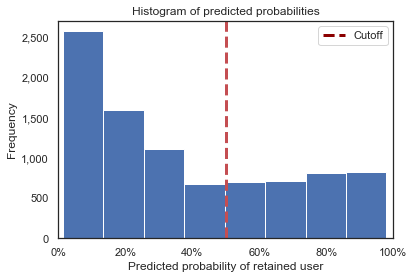



               precision    recall  f1-score   support

       False     0.8079    0.8591    0.8327      5615
        True     0.7389    0.6612    0.6978      3385

    accuracy                         0.7847      9000
   macro avg     0.7734    0.7601    0.7653      9000
weighted avg     0.7819    0.7847    0.7820      9000
 




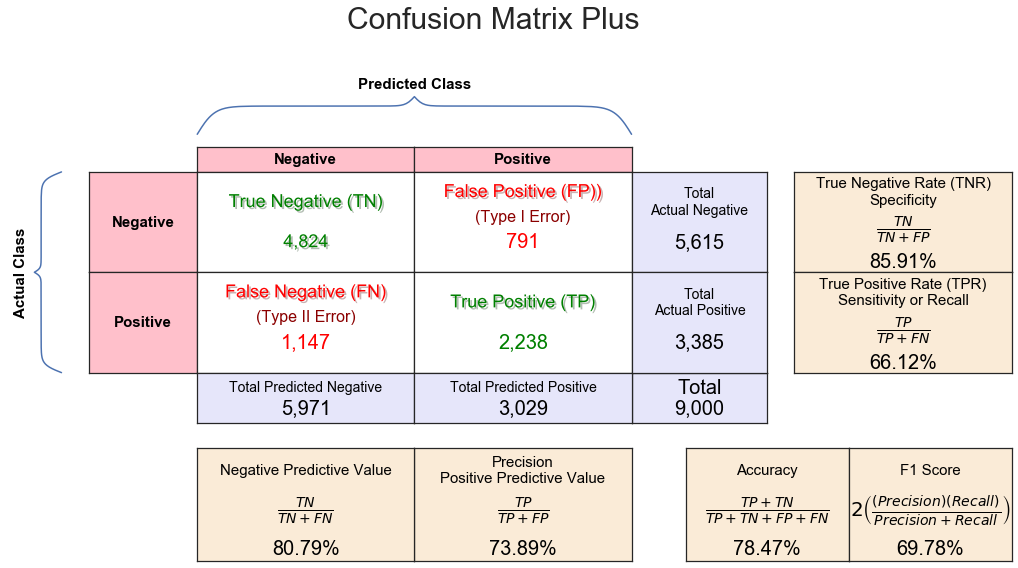

In [48]:
cutoff_middle  = 0.5
y_pred_class = binarize(y_pred_prob.reshape(1,-1), cutoff_middle)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class.ravel()).ravel()
pred_prob_hist(X_valid, bins=8, xlabel='retained user', cutoff=cutoff_middle)
print('\n', classification_report(y_valid, y_pred_class.ravel(), digits=4), '\n')
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
bl()

### Determine optimal cutoff

Optimal cutoff: 33.59%


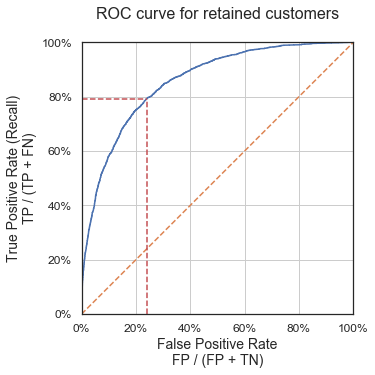

In [49]:
cutoff = plot_roc_curve(y_valid, y_pred_prob);
plt.plot()
print(f'Optimal cutoff: {cutoff:.2%}')

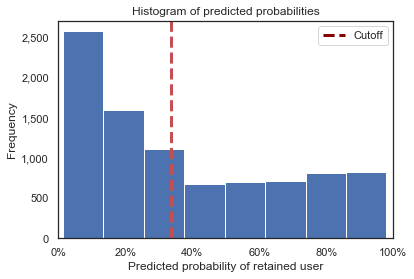



               precision    recall  f1-score   support

       False     0.8588    0.7605    0.8066      5615
        True     0.6661    0.7926    0.7239      3385

    accuracy                         0.7726      9000
   macro avg     0.7624    0.7765    0.7653      9000
weighted avg     0.7863    0.7726    0.7755      9000
 




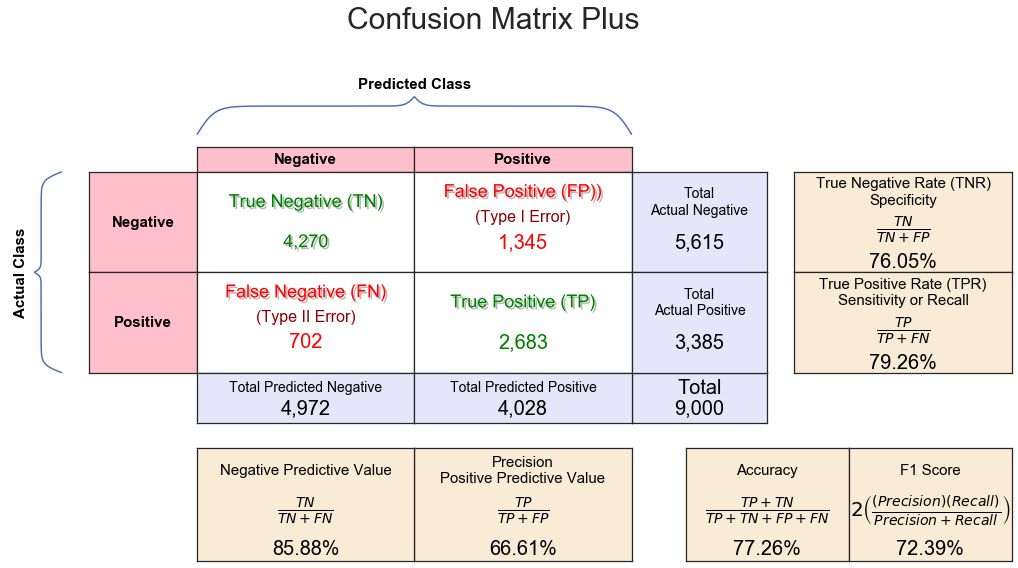

In [50]:
y_pred_class = binarize(y_pred_prob.reshape(-1,1), cutoff)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class).ravel()
pred_prob_hist(X_valid, bins=8, xlabel='retained user', cutoff=cutoff)
print('\n', classification_report(y_valid, y_pred_class, digits=4), '\n')
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
bl()

### Predict on test data


               precision    recall  f1-score   support

       False     0.8518    0.7753    0.8117      3120
        True     0.6755    0.7761    0.7223      1880

    accuracy                         0.7756      5000
   macro avg     0.7636    0.7757    0.7670      5000
weighted avg     0.7855    0.7756    0.7781      5000
 




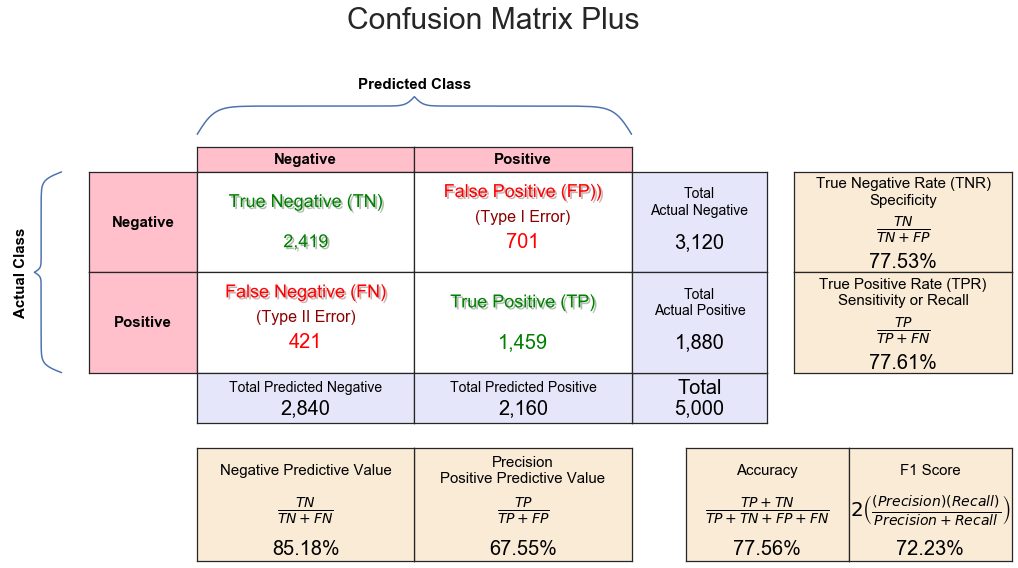

In [51]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_class = binarize(y_pred_prob.reshape(-1,1), cutoff)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()
print('\n', classification_report(y_test, y_pred_class, digits=4), '\n')
fig = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
fig.savefig('images/Optimize_cutoff_value')
bl()

## Method 3 - SMOTE oversampling

In [52]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [53]:
counter=Counter(df_ultimate['retained'])
print(counter)

Counter({False: 31196, True: 18804})


In [54]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, counts of label '1': 13539
Before OverSampling, counts of label '0': 22461 

After OverSampling, the shape of train_X: (44922, 12)
After OverSampling, the shape of train_y: (44922,) 

After OverSampling, counts of label '1': 22461
After OverSampling, counts of label '0': 22461


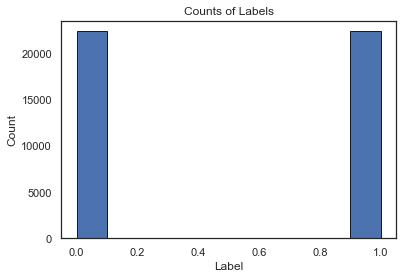

In [55]:
plt.hist(y_train_res.astype('int'), edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

In [56]:
# Model with default hyperparameters
model_smote = lgb.LGBMClassifier()
model_smote

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [57]:
start = timer()
model_smote.fit(X_train_res, y_train_res)
train_time = timer() - start

y_pred_prob = model_smote.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_pred_prob)

print('The baseline score (roc_auc) on the validation set is {:.4f}.'.format(auc))
print('The baseline training time is {:.2f} seconds'.format(train_time))

The baseline score (roc_auc) on the validation set is 0.8559.
The baseline training time is 0.53 seconds


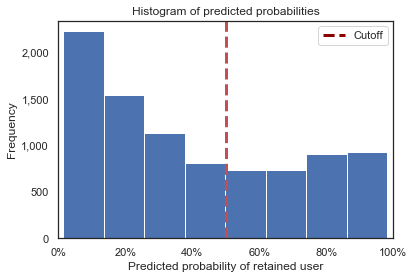



               precision    recall  f1-score   support

       False     0.8221    0.8354    0.8287      5615
        True     0.7195    0.7001    0.7097      3385

    accuracy                         0.7846      9000
   macro avg     0.7708    0.7678    0.7692      9000
weighted avg     0.7835    0.7846    0.7840      9000
 




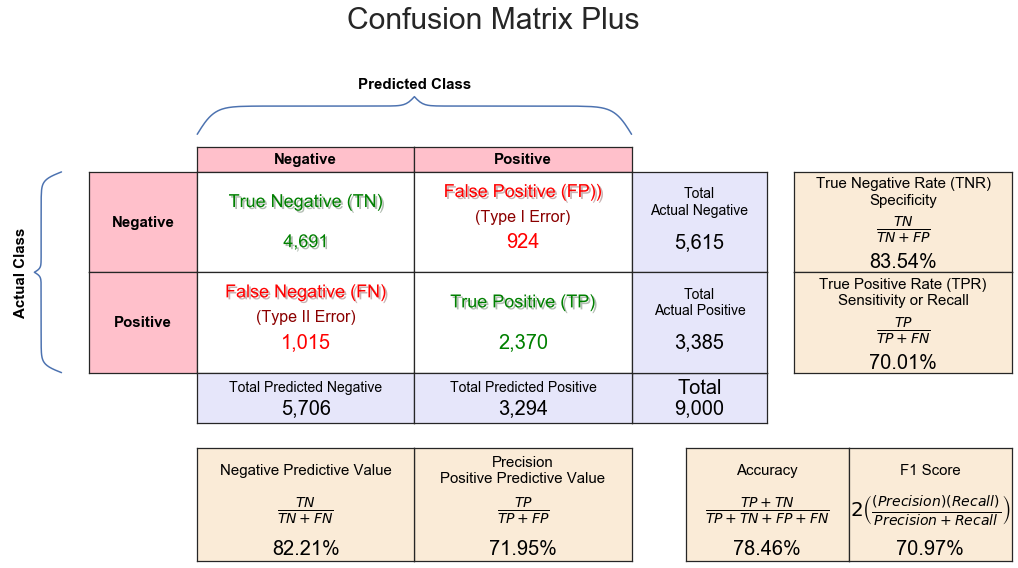

In [58]:
cutoff_middle  = 0.5
y_pred_class = binarize(y_pred_prob.reshape(1,-1), cutoff_middle)
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_class.ravel()).ravel()
pred_prob_hist(X_valid, bins=8, xlabel='retained user', cutoff=cutoff_middle)
print('\n', classification_report(y_valid, y_pred_class.ravel(), digits=4), '\n')
_ = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
bl()

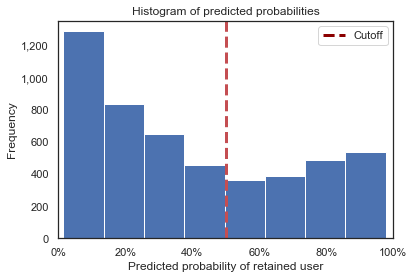



               precision    recall  f1-score   support

       False     0.8196    0.8490    0.8341      3120
        True     0.7336    0.6899    0.7111      1880

    accuracy                         0.7892      5000
   macro avg     0.7766    0.7695    0.7726      5000
weighted avg     0.7873    0.7892    0.7878      5000
 




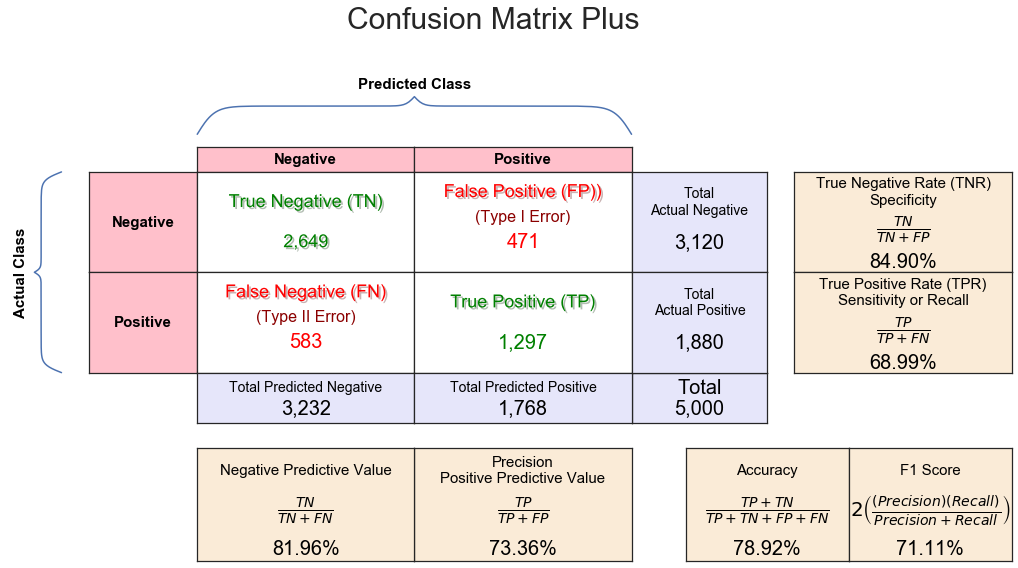

In [61]:
y_pred_prob = model_smote.predict_proba(X_test)[:, 1]
y_pred_class = binarize(y_pred_prob.reshape(1,-1), cutoff_middle)
auc = roc_auc_score(y_test, y_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class.ravel()).ravel()
pred_prob_hist(X_test, bins=8, xlabel='retained user', cutoff=cutoff_middle)
print('\n', classification_report(y_test, y_pred_class.ravel(), digits=4), '\n')
fig = plot_cm_plus(tn=tn, fp=fp, fn=fn, tp=tp)
fig.savefig('images/SMOTE_oversampling_confusion_matrix')
bl()